In [61]:
import torch
import numpy as np
import meshzoo
from math import sqrt
import matplotlib.pyplot as plt

from torchfem.elements import linear_to_quadratic
from torchfem import Planar
from torchfem.materials import IsotropicPlaneStress
from torchfem.io import import_mesh
from torchfem.examples import get_example_file

# Set double precision
torch.set_default_dtype(torch.float64)

# Material model (plane stress)
material = IsotropicPlaneStress(E=1000.0, nu=0.3)

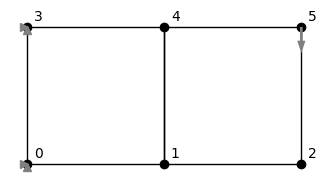

In [62]:
nodes = 0.2 * torch.tensor(
    [[0.0, 0.0], [1.0, 0.0], [2.0, 0.0], [0.0, 1.0], [1.0, 1.0], [2.0, 1.0]]
)
elements = torch.tensor([[0, 1, 4, 3], [1, 2, 5, 4]])

# Load at tip
tip = (nodes[:, 0] == 0.2 * 2.0) & (nodes[:, 1] == 0.2 * 1.0)
forces = torch.zeros_like(nodes)
forces[tip, 1] = -1.0

# Constrained displacement at left end
left = nodes[:, 0] == 0.0
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[left, :] = True

# Thickness
thickness = 0.1 * torch.ones(len(elements))

# Create model
cantilever = Planar(
    nodes, elements, forces, displacements, constraints, thickness, material.C()
)

cantilever.plot(node_markers="o", node_labels=True, figsize=(4, 2))

## A simple cantilever beam with first order quads

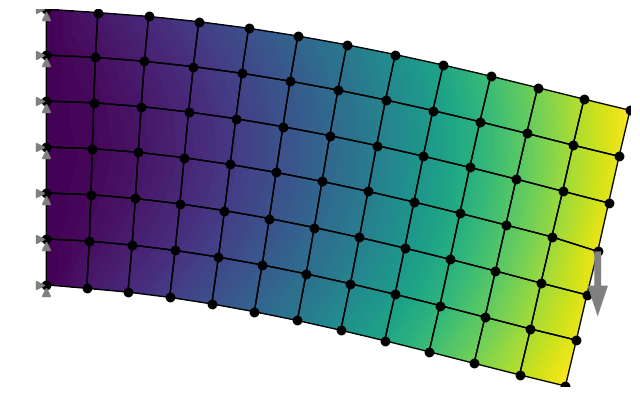

In [63]:
points, cells = meshzoo.rectangle_quad(
    np.linspace(0.0, 2.0, 13),
    np.linspace(0.0, 1.0, 7),
    cell_type="quad4",
)
nodes = torch.tensor(points, dtype=torch.get_default_dtype())
elements = torch.tensor(cells.tolist())

# Load at tip
tip = (nodes[:, 0] == 2.0) & (nodes[:, 1] == 0.5)
forces = torch.zeros_like(nodes)
forces[tip, 1] = -1.0

# Constrained displacement at left end
left = nodes[:, 0] == 0.0
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[left, :] = True

# Thickness
thickness = 0.1 * torch.ones(len(elements))

# Create model
cantilever = Planar(
    nodes, elements, forces, displacements, constraints, thickness, material.C()
)

# Solve
u, f = cantilever.solve()

# Plot
cantilever.plot(u, node_property=torch.norm(u, dim=1), node_markers=True)

## A simple cantilever beam with second order quads

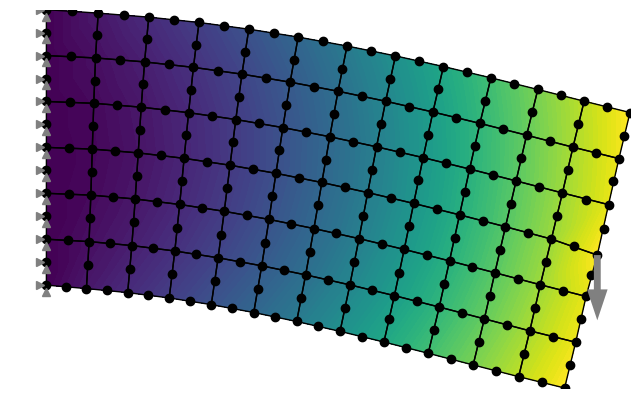

In [64]:
# Upgrade elements to quadratic
nodes, elements = linear_to_quadratic(nodes, elements)

# Load at tip
tip = (nodes[:, 0] == 2.0) & (nodes[:, 1] == 0.5)
forces = torch.zeros_like(nodes)
forces[tip, 1] = -1.0

# Constrained displacement at left end
left = nodes[:, 0] == 0.0
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[left, :] = True

# Thickness
thickness = 0.1 * torch.ones(len(elements))

# Create model
cantilever = Planar(
    nodes, elements, forces, displacements, constraints, thickness, material.C()
)

# Solve
u, f = cantilever.solve()

# Plot
cantilever.plot(u, node_property=torch.norm(u, dim=1), node_markers=True)

## A simple cantilever beam with first order triangles 

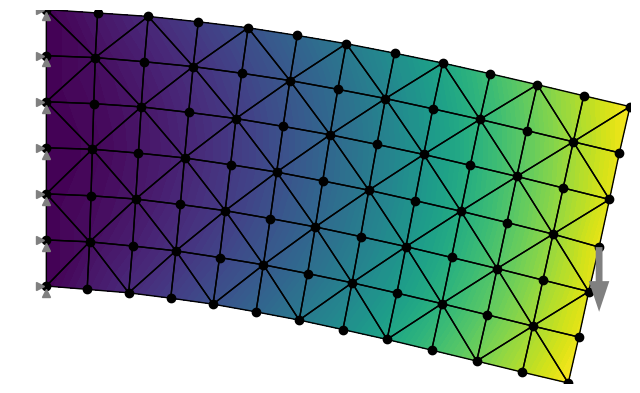

In [65]:
points, cells = meshzoo.rectangle_tri(
    np.linspace(0.0, 2.0, 13),
    np.linspace(0.0, 1.0, 7),
    variant="zigzag",
)
nodes = torch.tensor(points, dtype=torch.get_default_dtype())
elements = torch.tensor(cells.tolist())

# Load at tip
tip = (nodes[:, 0] == 2.0) & (nodes[:, 1] == 0.5)
forces = torch.zeros_like(nodes)
forces[tip, 1] = -1.0

# Constrained displacement at left end
left = nodes[:, 0] == 0.0
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[left, :] = True

# Thickness
thickness = 0.1 * torch.ones(len(elements))

cantilever = Planar(
    nodes, elements, forces, displacements, constraints, thickness, material.C()
)
# Solve
u, f = cantilever.solve()
# Plot
cantilever.plot(u, node_property=torch.norm(u, dim=1), node_markers=True)

## A simple cantilever beam with second order triangles 

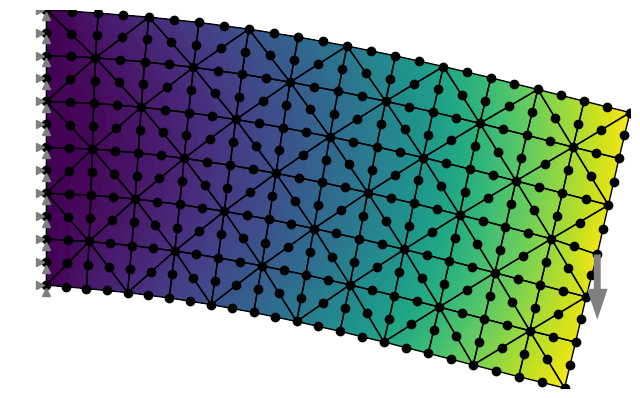

In [66]:
# Upgrade elements to quadratic
nodes, elements = linear_to_quadratic(nodes, elements)

# Load at tip
tip = (nodes[:, 0] == 2.0) & (nodes[:, 1] == 0.5)
forces = torch.zeros_like(nodes)
forces[tip, 1] = -1.0

# Constrained displacement at left end
left = nodes[:, 0] == 0.0
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[left, :] = True

# Thickness
thickness = 0.1 * torch.ones(len(elements))

# Create model
cantilever = Planar(
    nodes, elements, forces, displacements, constraints, thickness, material.C()
)
# Solve
u, f = cantilever.solve()

# Plot
cantilever.plot(u, node_property=torch.norm(u, dim=1), node_markers=True)

## A simple fillet in 2D 

In [67]:
# Import mesh
specimen = import_mesh(get_example_file("fillet.vtu"), C=material.C())

# Symmetry nodes
left = specimen.nodes[:, 0] < 0.1
specimen.constraints[left, 0] = True
bottom = specimen.nodes[:, 1] < 0.1
specimen.constraints[bottom, 1] = True

# Load at right end
right = specimen.nodes[:, 0] >= specimen.nodes[:, 0].max() - 0.1
specimen.constraints[right, 0] = True
specimen.displacements[right, 0] = 6.0

In [68]:
u, f = specimen.solve()

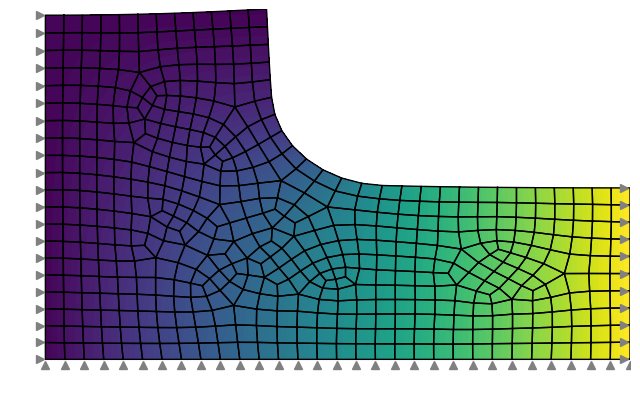

In [69]:
specimen.plot(u, node_property=u[:, 0], figsize=(8, 8))

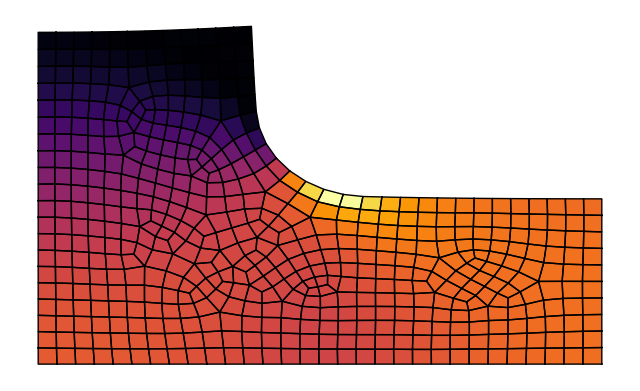

In [70]:
# Stress
mises = specimen.compute_stress(u, mises=True)
specimen.plot(u, bcs=False, element_property=mises, figsize=(8, 8), cmap="inferno")

## Plasticity




In [71]:
# Dimensions (thickness of plate t and edge length L)
t = 0.01
L = 0.2

# Applied load
load = 5.0

# Elastic material properties (plane stress)
material = IsotropicPlaneStress(E=1000.0, nu=0.3)
C = material.C()
S = torch.linalg.inv(C)
G = material.G()
E = material.E()
nu = material.nu()

# Increments
N = 20

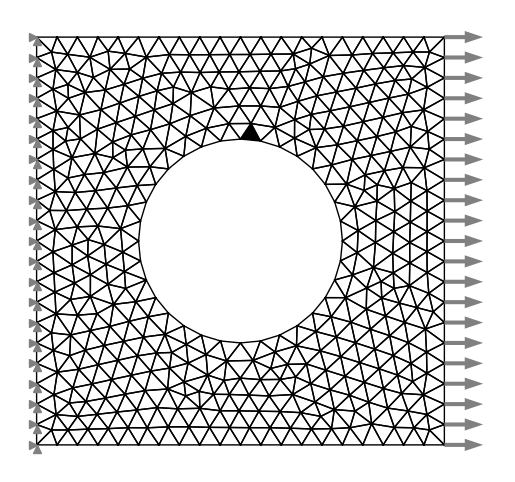

In [72]:
# Import mesh
plate = import_mesh(get_example_file("plate_hole.vtk"), C=C)
plate.thickness = t * torch.ones(len(plate.elements))

# Fixed boundary at left end
left = plate.nodes[:, 0] < 1e-6
plate.constraints[left] = True

# Load at right end
right = plate.nodes[:, 0] > L - 1e-6
force_increment = load * L * t / N
weigths = 2.0 * torch.ones(right.sum())
weigths[0] = 1.0
weigths[1] = 1.0
plate.forces[right, 0] = force_increment * weigths / weigths.sum()

# Indicator function to highlight the element for later comparison
indicator = torch.zeros(len(plate.elements))
indicator[405] = 1.0

plate.plot(element_property=indicator, cmap="gray_r")

### Plasticity model 

This is a simple isotropic hardening model.

In [73]:
sigma_y = 10.0
k = 10.0


def sigma_f(q):
    return sigma_y + k * q


def sigma_f_prime(q):
    return k

https://doi.org/10.1002/9780470694626.ch9  (Box 9.4,9.5,9.6)



In [74]:
P = 1 / 3 * torch.tensor([[2, -1, 0], [-1, 2, 0], [0, 0, 6]])


# Initialize variables
n_elem = len(plate.elements)
u = torch.zeros_like(plate.nodes)
epsilon = torch.zeros((n_elem, 3))
sigma = torch.zeros((n_elem, 3))
q = torch.zeros((n_elem))


stress = [0.0]
strain = [0.0]
peeq = [0.0]

for i in range(N):
    # Solve small deformation increment
    du, df = plate.solve()

    # Strain increment
    de = plate.compute_strain(du)
    epsilon += de

    # Compute trial stress
    ds = torch.einsum("...ij,...j->...i", C, de)
    s_trial = sigma + ds

    # Flow potential
    a1 = (s_trial[:, 0] + s_trial[:, 1]) ** 2
    a2 = (s_trial[:, 1] - s_trial[:, 0]) ** 2
    a3 = s_trial[:, 2] ** 2
    xi_trial = 1 / 6 * a1 + 1 / 2 * a2 + 2 * a3
    psi = 1 / 2 * xi_trial - 1 / 3 * sigma_f(q) ** 2

    # Flow mask
    fm = psi > 0

    # Newton solver to find plastic strain increment
    dGamma = torch.zeros_like(psi[fm])
    for j in range(10):
        # Compute xi and some short hands
        xi = (
            a1[fm] / (6 * (1 + E * dGamma / (3 * (1 - nu))) ** 2)
            + (1 / 2 * a2[fm] + 2 * a3[fm]) / (1 + 2 * G * dGamma) ** 2
        )
        sxi = torch.sqrt(xi)
        qq = q[fm] + dGamma * torch.sqrt(2 / 3 * xi)

        # Compute residual
        res = 1 / 2 * xi - 1 / 3 * sigma_f(qq) ** 2

        # Compute derivative of residual w.r.t dGamma
        H = sigma_f_prime(qq)
        xi_p = (
            -a1[fm] / (9 * (1 + E * dGamma / (3 * (1 - nu))) ** 3) * E / (1 - nu)
            - 2 * G * (a2[fm] + 4 * a3[fm]) / (1 + 2 * G * dGamma) ** 3
        )
        H_p = 2 * sigma_f(qq) * H * sqrt(2 / 3) * (sxi + dGamma * xi_p / (2 * sxi))
        res_prime = 1 / 2 * xi_p - 1 / 3 * H_p

        # Update dGamma
        dGamma -= res / res_prime

    if (torch.abs(res) > 1e-10).any():
        print("Local Newton iteration did not converge")

    # Compute inverse operator
    inv = torch.linalg.inv(S + dGamma[:, None, None] * P)

    # Update stress
    sigma[~fm] = s_trial[~fm]
    sigma[fm] = (inv @ S @ s_trial[fm][:, :, None]).squeeze(-1)

    # Update plastic strain
    q[fm] = qq

    # Update algorithmic tangent
    plate.C[~fm] = C
    xi = sigma[fm][:, :, None].transpose(-1, -2) @ P @ sigma[fm][:, :, None]
    H = sigma_f_prime(q[fm])
    n = inv @ P @ sigma[fm][:, :, None]
    alpha = 1 / (
        sigma[fm][:, :, None].transpose(-1, -2) @ P @ n
        + 2 * xi * H / (3 - 2 * H * dGamma[:, None, None])
    )
    plate.C[fm] = inv - alpha * n @ n.transpose(-1, -2)

    # Update displacement
    u += du

    # Store data of most critical element
    stress.append(sigma[405, 0].item())
    strain.append(epsilon[405, 0].item())
    peeq.append(q[405].item())

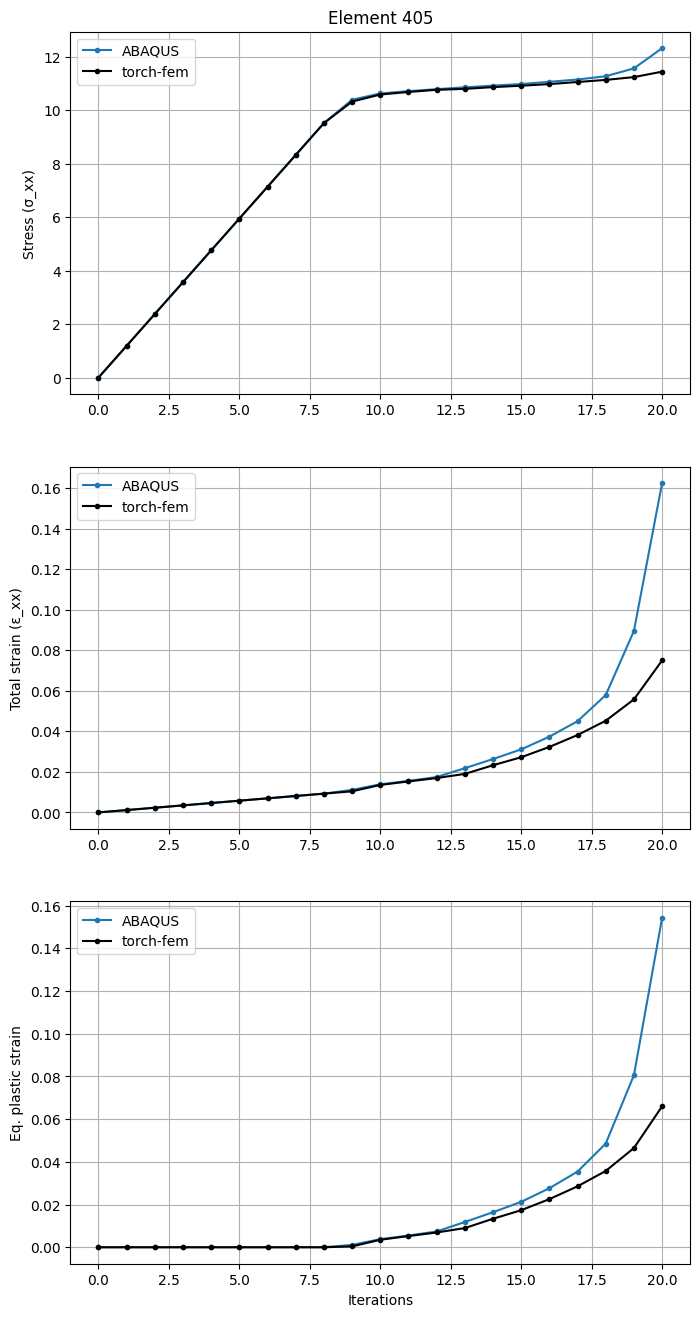

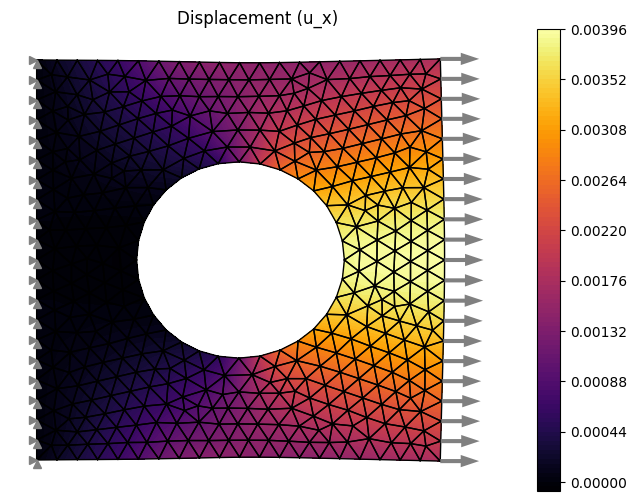

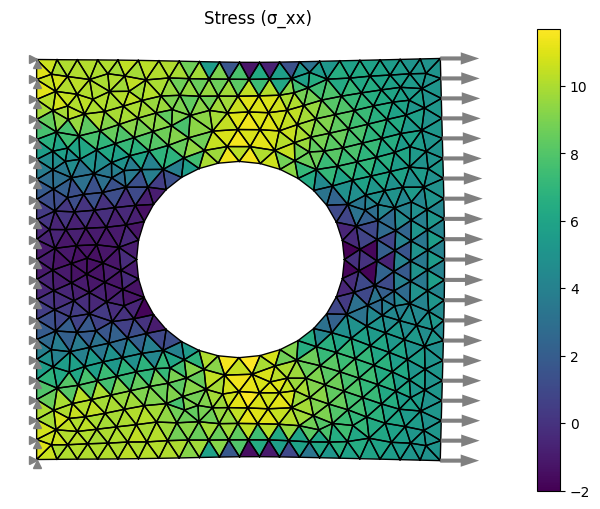

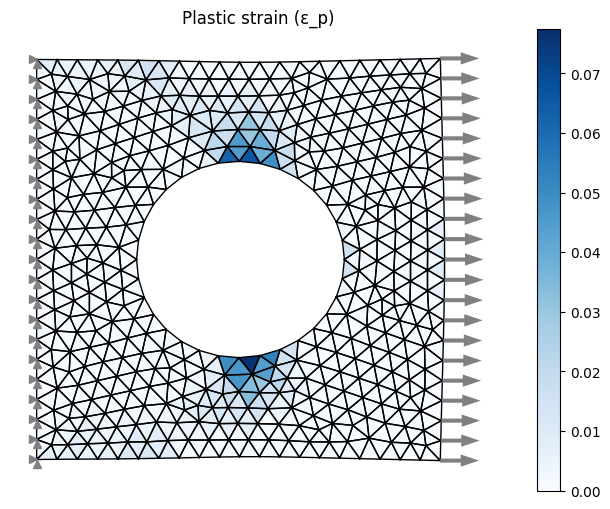

In [75]:
ref_data = np.array(
    [
        [0, 0, 0.00000],
        [0.00115863, 0, 1.18972],
        [0.00231726, 0, 2.37944],
        [0.00347588, 0, 3.56916],
        [0.00463451, 0, 4.75888],
        [0.00579314, 0, 5.94860],
        [0.00695177, 0, 7.13832],
        [0.00811039, 0, 8.32804],
        [0.00926902, 0, 9.51776],
        [0.0111287, 0.00109242, 10.3928],
        [0.0138697, 0.00378789, 10.6270],
        [0.0155667, 0.00548699, 10.7136],
        [0.0174585, 0.007391, 10.7888],
        [0.0218321, 0.0118273, 10.8568],
        [0.0263462, 0.0164109, 10.9203],
        [0.0311143, 0.0212644, 10.9806],
        [0.0373726, 0.0276408, 11.0636],
        [0.0450277, 0.0354477, 11.1487],
        [0.057917, 0.0485668, 11.2713],
        [0.0895547, 0.0805989, 11.5656],
        [0.162536, 0.154277, 12.3205],
    ]
)


fig, ax = plt.subplots(3, 1, figsize=(8, 16))
ax[0].plot(ref_data[:, 2], ".-", label="ABAQUS")
ax[0].plot(stress, ".-k", label="torch-fem")
ax[0].grid()
ax[0].title.set_text("Element 405")
ax[0].set_ylabel("Stress (σ_xx)")
ax[0].legend()

ax[1].plot(ref_data[:, 0], ".-", label="ABAQUS")
ax[1].plot(strain, ".-k", label="torch-fem")
ax[1].grid()
ax[1].set_ylabel("Total strain (ε_xx)")
ax[1].legend()

ax[2].plot(ref_data[:, 1], ".-", label="ABAQUS")
ax[2].plot(peeq, ".-k", label="torch-fem")
ax[2].set_ylabel("Eq. plastic strain")
ax[2].set_xlabel("Strain")
ax[2].grid()
ax[2].legend()
ax[2].set_xlabel("Iterations")
plt.show()

plate.plot(
    u=u,
    node_property=u[:, 0],
    cmap="inferno",
    colorbar=True,
    title="Displacement (u_x)",
)
plate.plot(
    u=u,
    element_property=sigma[:, 0],
    cmap="viridis",
    colorbar=True,
    title="Stress (σ_xx)",
)
plate.plot(
    u=u,
    element_property=q,
    cmap="Blues",
    colorbar=True,
    title="Plastic strain (ε_p)",
)